# Exponential smoothing sampling

In [1]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn.objects as so

pd.set_option("mode.copy_on_write", True)

In [2]:
COL_VAL = "val"
EXP_SMOOTH_ALPHA = 0.3

## Plotting helper functions

In [3]:
def plot_dists(df_orig, df_new):
    df_disp = pd.concat([
        df_orig.assign(df_name="original"),
        df_new.assign(df_name="new")
    ])
    return (
        so.Plot(df_disp, x=COL_VAL, color="df_name")
        .add(so.Bars(), so.Hist())
    )

## Prepare data

In [4]:
def generate_skewed_dataset(sample_size):
    return pd.DataFrame({
        COL_VAL: np.floor(np.random.exponential(0.3, size=sample_size) * 1000)
    }).astype({COL_VAL: int})

In [5]:
df_orig = generate_skewed_dataset(10_000)
df_orig.head(5)

,val
0,1204
1,707
2,1140
3,64
4,556


## With Pandas

In [6]:
def exponential_smoothing_sampling(df):
    col_count = "count"
    dict_weight = dict(
        df[COL_VAL]
        .value_counts()
        .reset_index()
        .rename(columns={0: col_count})
        .assign(weight=lambda df_: df_[col_count] ** EXP_SMOOTH_ALPHA / df_[col_count])
        [[COL_VAL, "weight"]]
        .values
    )

    return (df
        .assign(weight=df[COL_VAL].apply(lambda x: dict_weight[x]))
        .sample(len(df), replace=True, weights="weight")
    )

In [7]:
%%time

df_sampled_pd = df_orig.pipe(exponential_smoothing_sampling)

CPU times: user 13.7 ms, sys: 2.74 ms, total: 16.5 ms
Wall time: 14.7 ms


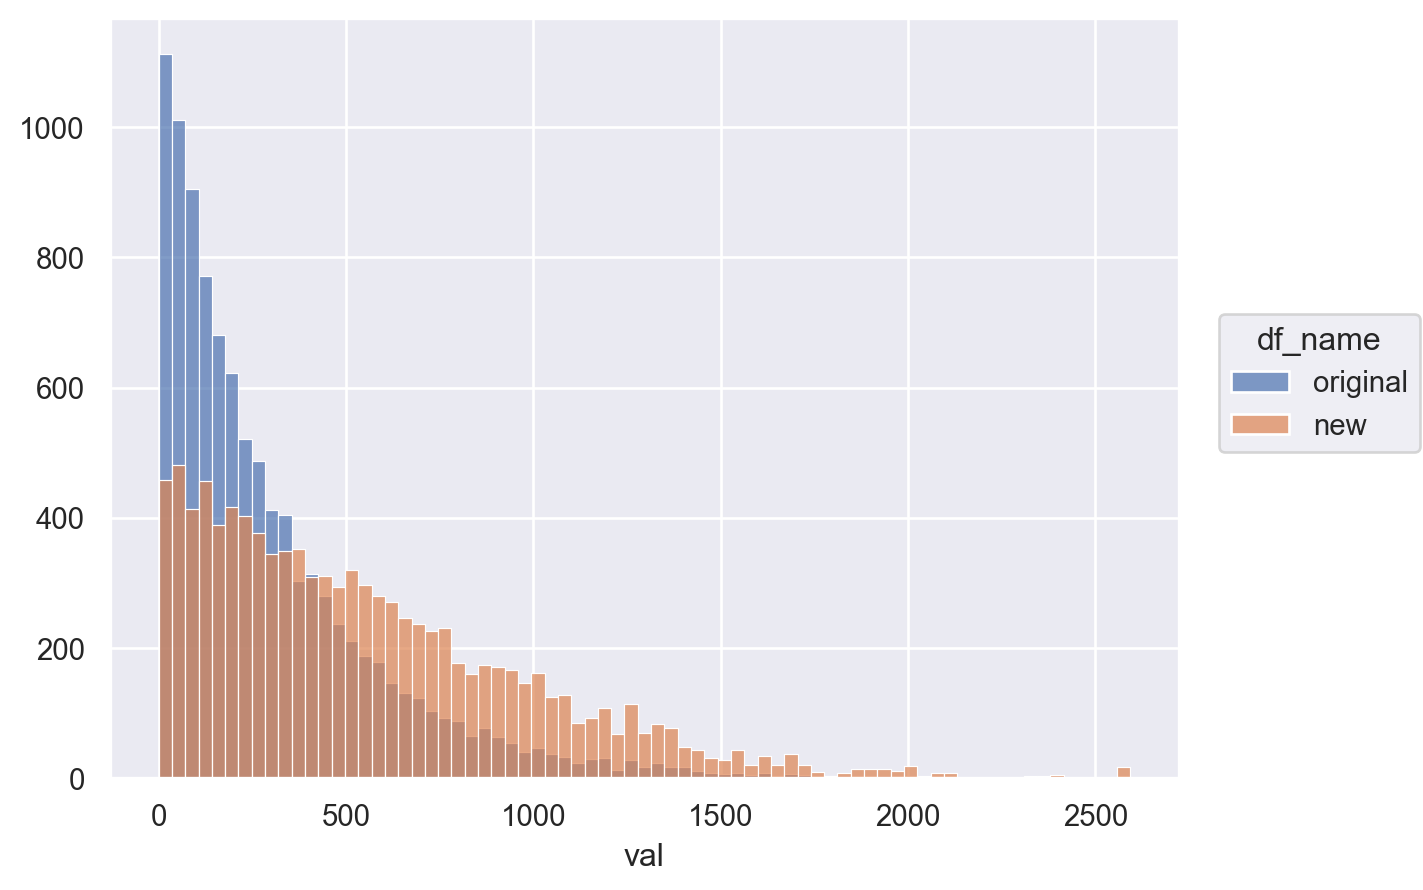

In [8]:
plot_dists(df_orig, df_sampled_pd)

## With Polars

https://github.com/pola-rs/polars/issues/2661
https://github.com/pola-rs/polars/pull/11943

In [9]:
def run_on_polars(df, f, /, *args, **kwargs):
    return (pl.from_pandas(df)
        .lazy()
        .pipe(f, *args, **kwargs)
        .collect()
        .to_pandas()
    )
    
def exponential_smoothing_sampling_w_polars(lf):
    sample_size = lf.select(pl.len()).collect().item()
    index_name = "row_idx"
    
    return (lf
        .pipe(add_probabilities)
        .with_row_index(index_name)
        .group_by(COL_VAL)
        .agg([
            pl.col(index_name).sample(
                fraction=pl.col("p").first() * sample_size,
                with_replacement=True, seed=1
            )
        ])
        .explode(index_name)
        .drop_nulls(index_name)
    )

def add_probabilities(lf):
    lf_p = (lf
        .group_by("val").len()
        .with_columns(weight=pl.col("len") ** EXP_SMOOTH_ALPHA / pl.col("len"))
        .with_columns(weight_subtotal=pl.col("len") * pl.col("weight"))
        .with_columns(p=pl.col("weight") / pl.col("weight_subtotal").sum())
        .select(["val", "p"])
    )
    return lf.join(lf_p, on="val")

In [10]:
%%time

df_sampled_pl = df_orig.pipe(run_on_polars, exponential_smoothing_sampling_w_polars)

CPU times: user 17 ms, sys: 18.3 ms, total: 35.4 ms
Wall time: 14.4 ms


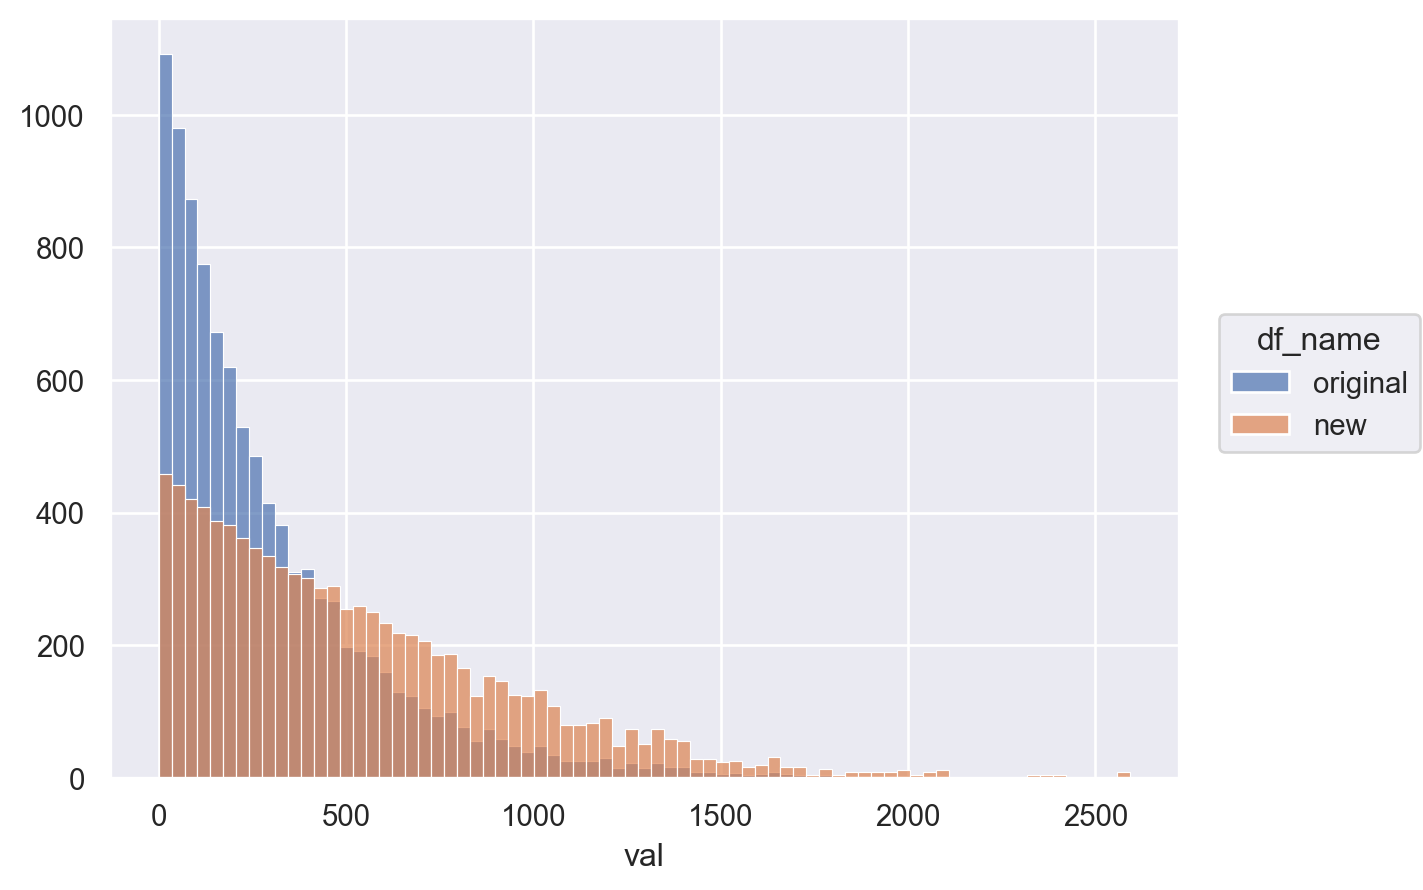

In [11]:
plot_dists(df_orig, df_sampled_pl)

## Now with a bigger dataset

In [12]:
%%time

df_big_orig = generate_skewed_dataset(30_000_000)

CPU times: user 907 ms, sys: 335 ms, total: 1.24 s
Wall time: 1.25 s


In [13]:
%%time

df_big_sampled_pd = df_big_orig.pipe(exponential_smoothing_sampling)
del df_big_sampled_pd

CPU times: user 48.6 s, sys: 1.83 s, total: 50.4 s
Wall time: 50.6 s


In [14]:
%%time

df_big_sampled_pl = df_big_orig.pipe(run_on_polars, exponential_smoothing_sampling_w_polars)
del df_big_sampled_pl

CPU times: user 4.66 s, sys: 1.31 s, total: 5.97 s
Wall time: 1.84 s
